Look at some form of summarized coverage with a break-out by PCC's.
- Use shop vol counts from coverage data

Version Notes
- history: Brached from 10d.
- a: filter out 0-days from dept / same-day searches
- b: clean up code from a

Previous Version notes:
- Expand / modify "average" coverage score, following discussion with Joel Fisher and Greg H
    - they are most interested in knowing where "drop-off" in coverage occurs
        - implied, not stated: with respect to market volume
    - "high" / "good-enough" coverage depends on how good mechanisms to fill gaps are
        - so, for now, assume close to 100%, at least only missing 1/30 days (96.66%)

## import, setup

In [1]:
from functools import reduce
import datetime
from calendar import Calendar
import argparse

import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.window import Window

# for notebook
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", 100)

In [2]:
import matplotlib.cm as cm

Need to re-compute coverage summary, so run in cluster mode

In [3]:
APP_NAME = "KF-ShopGrid-Jupyter"

# SET UP SPARK
# ----------------
run_mode = "python" 

if run_mode == "python":
    conf1 = pyspark.SparkConf().setAll([
        ("spark.app.name", APP_NAME),
        ("spark.driver.memory","20g"),
        ("spark.master","yarn"),
        ("spark.executor.memory", "10g"),
        ("spark.executor.instances", 8),
        ("spark.executor.cores", "5"),
#         ('spark.sql.crossJoin.enabled', True),
#         ('spark.sql.shuffle.partitions', 8) 
        ])
    spark = SparkSession.builder.config(conf = conf1).getOrCreate()
elif run_mode == "spark-submit":
    spark = SparkSession.builder.appName(APP_NAME).getOrCreate()
else:
    pass

spark.sparkContext.applicationId

'application_1658797823938_3286'

## args

From previous analysis, we know that some markets have poor coverage for same-day searches, but good coverage otherwise. So set min dtd to 1 (not 0)

In [4]:
# define things
min_days_til_dept = 1 # new in notebook -- need to add to args
max_days_til_dept = 120 # args.days_til_dept
max_stay_duration = 30 #args.length_of_stay

missing_search_days_str = [] #args.missing_dates or []
num_missing_days = len(missing_search_days_str)

# filter on LOS, to restrict our analysis
los_start, los_end = 1, 7

# load & prep data

TODO: combine data from different "versions" of shop_vol data

In [5]:
# coverage input data
input_dir = "/user/kendra.frederick/shop_vol/v5/decoded/with_pcc/"
cov_df = spark.read.option("mergeSchema", True).parquet(input_dir)

# NEW: derive shopping dates from data, instead of them being supplied as arguments
search_start_str = cov_df.select(F.min("searchDt").alias("x")).collect()[0]["x"]
search_end_str = cov_df.select(F.max("searchDt").alias("x")).collect()[0]["x"]

search_start = datetime.datetime.strptime(str(search_start_str), "%Y%m%d").date()
search_end = datetime.datetime.strptime(str(search_end_str), "%Y%m%d").date()

num_search_days = (search_end - search_start).days + 1
num_search_days_adj = num_search_days - num_missing_days

# min_dept_dt, max_dept_dt, max_return_dt
search_start, search_end, num_search_days

(datetime.date(2022, 8, 22), datetime.date(2022, 8, 31), 10)

In [6]:
# cov_df.show(5)

In [7]:
airport_df = spark.read.csv("/data/reference/AIRPORT.CSV", header=True)

# helper funcs

In [8]:
def process_coverage_data(df):
    # updated column names
    df = df.withColumn("market", 
    F.concat_ws("-", F.col("origin"), F.col("destination")))

    # convert Dept dates (which are strings) to datetime
    df.registerTempTable("data")
    df = spark.sql("""
        SELECT *,
            TO_DATE(CAST(UNIX_TIMESTAMP(CAST(outDeptDt AS string), 'yyyyMMdd') AS TIMESTAMP)) AS outDeptDt_dt,
            TO_DATE(CAST(UNIX_TIMESTAMP(CAST(inDeptDt AS string), 'yyyyMMdd') AS TIMESTAMP)) AS inDeptDt_dt,
            TO_DATE(CAST(UNIX_TIMESTAMP(CAST(searchDt AS string), 'yyyyMMdd') AS TIMESTAMP)) AS searchDt_dt
        FROM data
    """)

    # filter on round-trip
    df_filt = (df
                # Note: when we filter on stay duration below, this also
                # effectively accomplishes filtering on round-trip == 1
                .filter(F.col("round_trip") == 1)
            )
    
    # add stay_duration column & fitler on it
    df_filt = df_filt.withColumn('stay_duration', F.datediff(
                    F.col('inDeptDt_dt'), F.col('outDeptDt_dt'))
                )
    # Note this effectively filters out null stay durations, which are one-way trips
    df_filt = df_filt.filter(F.col('stay_duration').between(0, max_stay_duration))
    
    # Add days_til_dept column & filter on it
    df_filt = df_filt.withColumn('days_til_dept',
                    F.datediff(
                        F.col('outDeptDt_dt'), F.col('searchDt_dt'))
                    )
    df_filt = (df_filt
               .filter(F.col('days_til_dept')
                       .between(min_days_til_dept, max_days_til_dept))
              )
    
    # BY DAYS TIL DEPT
    dtd_df = (df_filt
                .groupBy(["market", "days_til_dept", "stay_duration", ])
              # add agg to pull shop counts over
                .agg(
                    F.countDistinct("searchDt_dt").alias("obs_num_days"),
                    F.sum("shop_counts").alias("shop_counts")
                )
                .withColumn("pct_shop_coverage", F.col("obs_num_days") / num_search_days)
                .withColumn("pct_shop_coverage_adj", F.col("obs_num_days") / num_search_days_adj)           
                .repartition("market")
              )
    return dtd_df

In [9]:

def plot_stacked_market_heatmap(covg_summ_pdf, sorted_market_list, start, num, add_y_labels=True):
    stop = start + num
    markets_to_plot = sorted_market_list[start:stop]
    adj_num = min(len(markets_to_plot), num)

    pvt = covg_summ_pdf.pivot(index='days_til_dept', columns='market', values='avg_coverage')
    pvt_to_plot = pvt[markets_to_plot].transpose()
    
    if add_y_labels:
        plot_height = int(adj_num/5)
    else:
        plot_height = int(adj_num/10)
    plt.figure(figsize=(15, plot_height))
    sns.heatmap(pvt_to_plot, cmap='Greens', vmin=0,
                yticklabels=add_y_labels,
                cbar_kws={'label': 'avg coverage', 'shrink': 0.5});
    # plt.title(f"Average coverage across {los_start}- to {los_end}-day trips // POS = {pos}  // markets {start} - {stop}");
    plt.title(f"Average coverage, markets {start} - {stop}");
    plt.show()


def plot_vol_vs_coverage(cov_summ_pdf):
    plt.figure(figsize=(8,5))
    plt.scatter(cov_summ_pdf['shop_counts'], cov_summ_pdf['avg_coverage'], alpha=0.5);
    plt.xlabel("shop counts");
    plt.ylabel("avg coverage");
    plt.title(f"Average coverage vs. volume");



def plot_violin_distro_vs_dtd(covg_summ_pdf, dtd_list=[14, 30, 60, 90, 120]):
    covg_summ_filt_pdf = covg_summ_pdf[covg_summ_pdf['days_til_dept'].isin(dtd_list)]
    sns.violinplot(covg_summ_filt_pdf['days_til_dept'], covg_summ_filt_pdf['trailing_avg_over_dtd'], palette="Greens");



def line_plot_coverage_vs_dtd(covg_summ_pdf, dtd_list=[14, 30, 60, 90, 120], use_color_map=False):
    cmap_name = "Greens"#"GnBu"
    if use_color_map:
        colors = [cm.get_cmap(cmap_name)(x) for x in np.linspace(0, 1, len(dtd_list)+1)]
    else:
        colors = ["blue", "orange", "green", "red", "cyan", "magenta", "yellow", "black"]

    plt.figure(figsize=(8,5))
    for i, dtd in enumerate(dtd_list):
        line_plot_df = covg_summ_pdf[covg_summ_pdf['days_til_dept'] == dtd]
        line_plot_df = line_plot_df.sort_values(by=["trailing_avg_over_dtd", "sum_counts"],
                                ascending=[False, False],
                                ).reset_index(drop=True)
        plt.plot(line_plot_df.index, line_plot_df['trailing_avg_over_dtd'],
                color=colors[i+1],
                label=f"{dtd} days out");    
        plt.legend();
        plt.title("Trailing average of coverage at various days til deptarture");
        plt.ylabel("avg coverage")
        plt.xlabel("market");


In [10]:

def analyze_pos(cov_df, pos, los_start, los_end, filter_on_org_dst=True):

    pos_cov_df = cov_df.filter(F.col("pos") == pos)

    if filter_on_org_dst:
        pos_cov_df = (pos_cov_df
                        .join(
                            airport_df.select('airport_code', 'country_code'),
                            on=[pos_cov_df['origin'] == airport_df['airport_code']],
                        ).withColumnRenamed("country_code", "origin_country")
                        .drop("airport_code")
                        )
        pos_cov_df = (pos_cov_df
                        .join(
                            airport_df.select('airport_code', 'country_code'),
                            on=[pos_cov_df['destination'] == airport_df['airport_code']],
                        ).withColumnRenamed("country_code", "destination_country")
                        .drop("airport_code")
                        )

        pos_cov_df = pos_cov_df.filter(
            (F.col('origin_country') == pos) | (F.col("destination_country") == pos)
        )

    pos_agg = process_coverage_data(pos_cov_df)

    # filter on LOS, to restrict our analysis
    pos_agg_los = pos_agg.filter(F.col("stay_duration").between(los_start, los_end))

    # take average coverage over this range of LOS
    pos_covg_summ = (pos_agg_los
                    .groupBy("market", "days_til_dept")
                    .agg(
                        F.mean("pct_shop_coverage").alias("avg_coverage"),
                        F.sum("shop_counts").alias("shop_counts")
                    )
                    )

    # compute trailing avg over days til dept
    w_trail = (Window
            .partitionBy("market")
            .orderBy("days_til_dept")
            .rangeBetween(Window.unboundedPreceding, Window.currentRow)
            )
    pos_covg_summ = (pos_covg_summ
                        .withColumn("trailing_avg_over_dtd",
                                    F.mean("avg_coverage").over(w_trail))
                        .withColumn("sum_counts",
                                    F.sum("shop_counts").over(w_trail))
                        )
    pos_cov_summ_pdf = pos_covg_summ.toPandas()

    return pos_cov_summ_pdf

def sort_markets_by_dtd_covg(covg_summ_pdf, dtd):
    # get market list sorted by trailing avg at `dtd` days until dept
    temp = covg_summ_pdf[covg_summ_pdf['days_til_dept'] == dtd]
    market_list_sorted = list(temp.sort_values(by=["trailing_avg_over_dtd", "sum_counts"],
                                            ascending=[False, False]
                                            )['market'])
    return market_list_sorted


# try it out: US

In [11]:
pos = 'US'
pos_cov_summ_pdf = analyze_pos(cov_df, pos, los_start, los_end, filter_on_org_dst=True)

In [13]:
pos_cov_summ_pdf.head()

,market,days_til_dept,avg_coverage,shop_counts,trailing_avg_over_dtd,sum_counts
0,LGW-JFK,1,1.0,6013,1.0,6013
1,LGW-JFK,2,1.0,5522,1.0,11535
2,LGW-JFK,3,1.0,6804,1.0,18339
3,LGW-JFK,4,1.0,6859,1.0,25198
4,LGW-JFK,5,1.0,9124,1.0,34322


In [14]:
market_list_sorted = sort_markets_by_dtd_covg(pos_cov_summ_pdf, 30)
len(market_list_sorted)

279

In [15]:
market_list_sorted[:5]

['LAX-JFK', 'JFK-MIA', 'LAX-EWR', 'EWR-MIA', 'JFK-LAX']

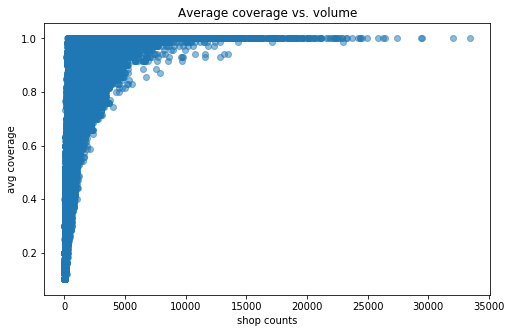

In [18]:
plot_vol_vs_coverage(pos_cov_summ_pdf)

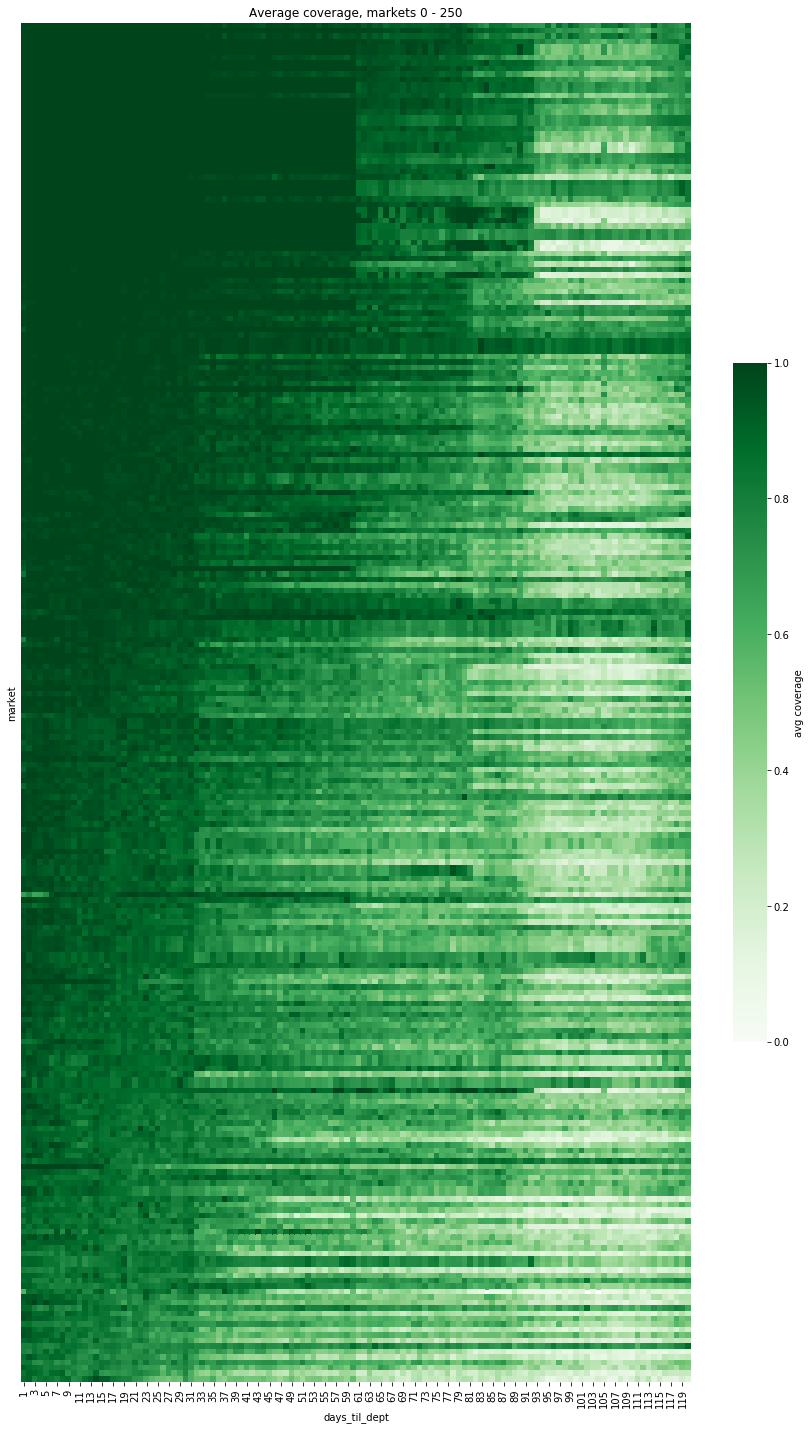

In [35]:
plot_stacked_market_heatmap(pos_cov_summ_pdf, market_list_sorted, 0, 250, False)

/opt/anaconda/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


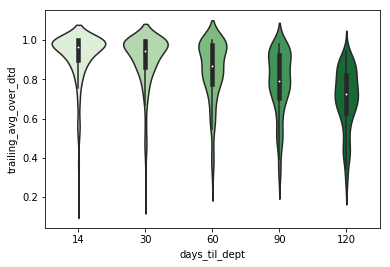

In [30]:
plot_violin_distro_vs_dtd(pos_cov_summ_pdf)

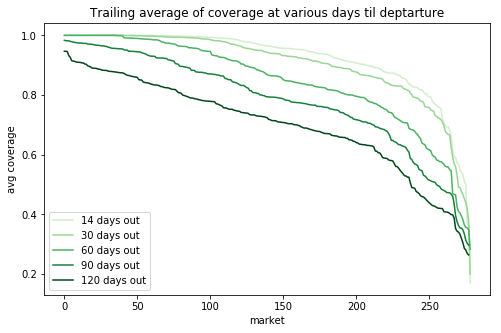

In [34]:
line_plot_coverage_vs_dtd(pos_cov_summ_pdf, use_color_map=True)

# that was fun - try another POS: IN

In [16]:
pos = 'IN'
los_start, los_end = 1, 7

pos_cov_summ_pdf = analyze_pos(cov_df, pos, los_start, los_end, filter_on_org_dst=True)
# pos_cov_summ_pdf.head()

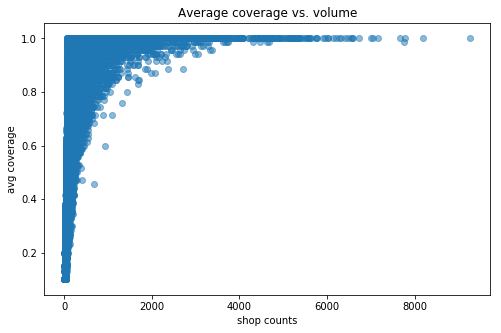

In [17]:
plot_vol_vs_coverage(pos_cov_summ_pdf)

In [20]:
market_list_sorted = sort_markets_by_dtd_covg(pos_cov_summ_pdf, 120)
len(market_list_sorted)

93

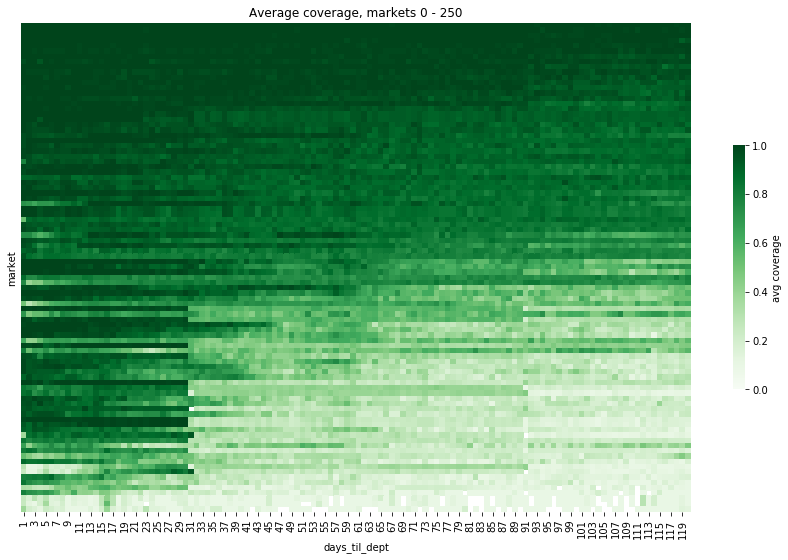

In [21]:
plot_stacked_market_heatmap(pos_cov_summ_pdf, market_list_sorted, 0, 250, False)

I tried sorting markets by different dtd trailing averages. Each one ended up looking weird in one way or another

/opt/anaconda/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


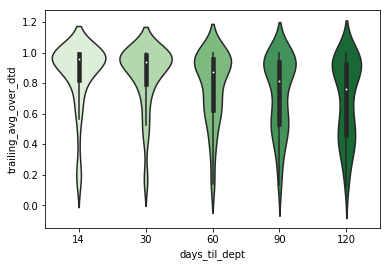

In [48]:
plot_violin_distro_vs_dtd(pos_cov_summ_pdf)

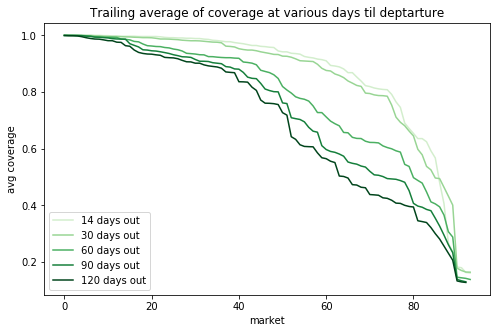

In [49]:
line_plot_coverage_vs_dtd(pos_cov_summ_pdf, use_color_map=True)

# UK

In [50]:
pos = 'GB'
los_start, los_end = 1, 7
pos_cov_summ_pdf = analyze_pos(cov_df, pos, los_start, los_end, filter_on_org_dst=True)
# pos_cov_summ_pdf.head()

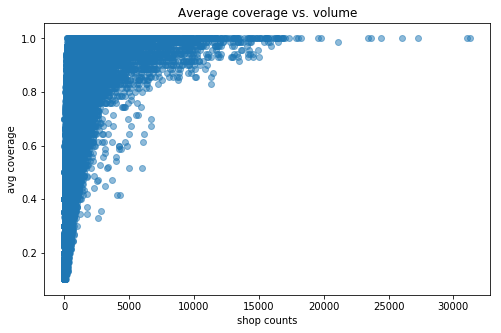

In [51]:
plot_vol_vs_coverage(pos_cov_summ_pdf)

In [52]:
market_list_sorted = sort_markets_by_dtd_covg(pos_cov_summ_pdf, 30)
# market_list_sorted[:5]

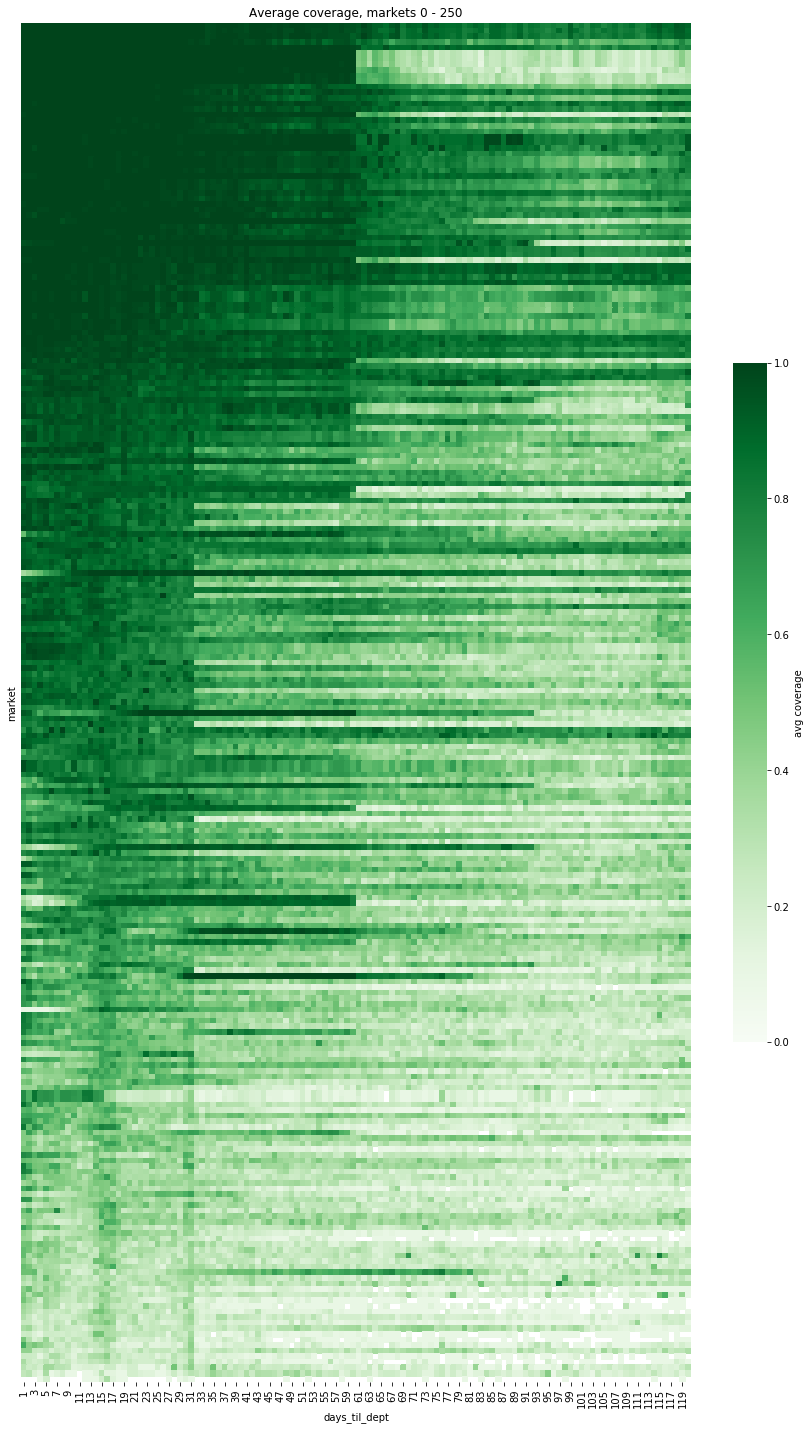

In [53]:
plot_stacked_market_heatmap(pos_cov_summ_pdf, market_list_sorted, 0, 250, False)

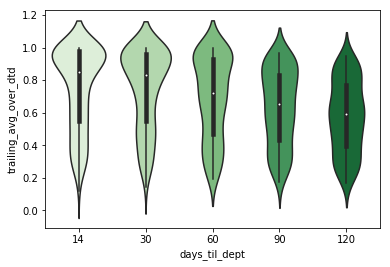

In [54]:
plot_violin_distro_vs_dtd(pos_cov_summ_pdf)

In [56]:
pos_cov_summ_pdf.head()

,market,days_til_dept,avg_coverage,shop_counts,trailing_avg_over_dtd,sum_counts
0,LCY-BCN,1,1.0,7263,1.0,7263
1,LCY-BCN,2,1.0,7440,1.0,14703
2,LCY-BCN,3,1.0,8135,1.0,22838
3,LCY-BCN,4,1.0,8013,1.0,30851
4,LCY-BCN,5,1.0,7306,1.0,38157


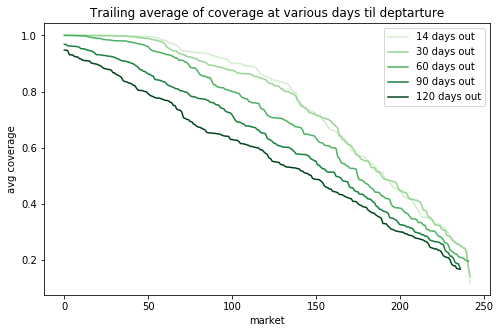

In [55]:
line_plot_coverage_vs_dtd(pos_cov_summ_pdf, use_color_map=True)

# FR

In [57]:
pos = 'FR'
pos_cov_summ_pdf = analyze_pos(cov_df, pos, los_start, los_end, filter_on_org_dst=True)
# pos_cov_summ_pdf.head()

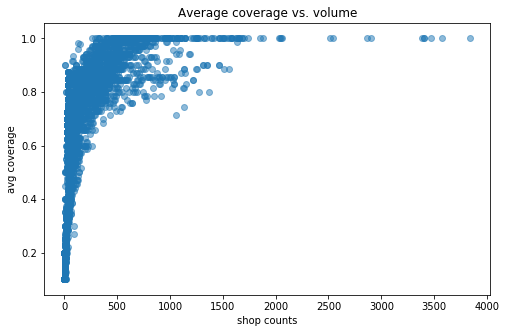

In [58]:
plot_vol_vs_coverage(pos_cov_summ_pdf)

In [59]:
market_list_sorted = sort_markets_by_dtd_covg(pos_cov_summ_pdf, 30)
# market_list_sorted[:5]

In [63]:
len(market_list_sorted)

46

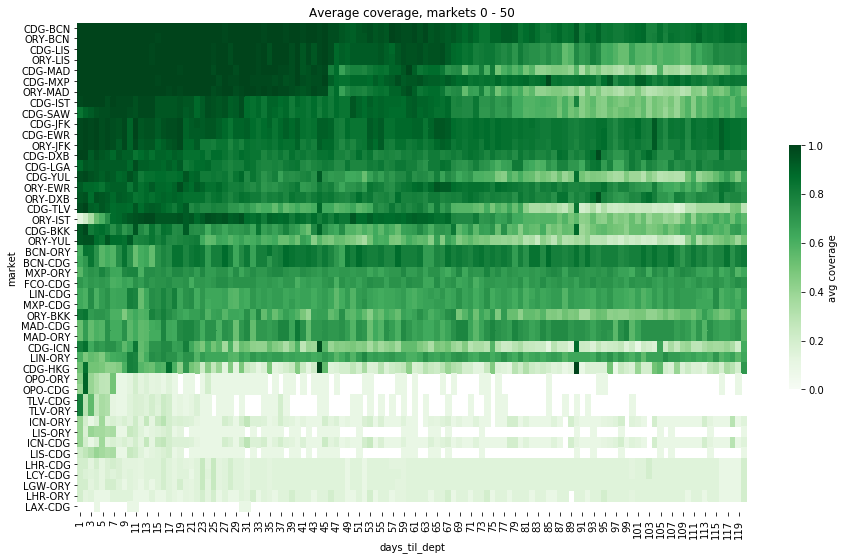

In [68]:
plot_stacked_market_heatmap(pos_cov_summ_pdf, market_list_sorted, 0, 50, True)

/opt/anaconda/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


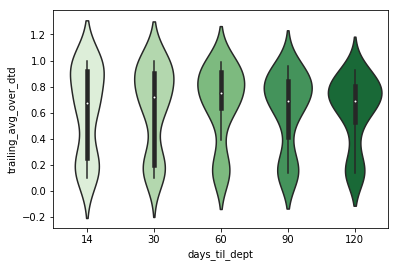

In [64]:
plot_violin_distro_vs_dtd(pos_cov_summ_pdf)

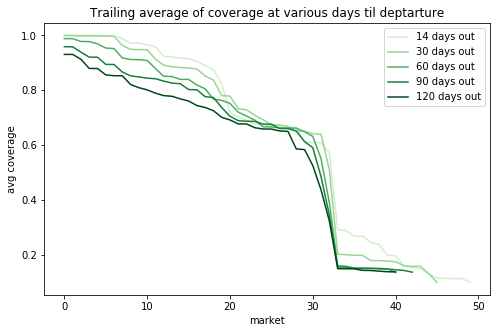

In [65]:
line_plot_coverage_vs_dtd(pos_cov_summ_pdf, use_color_map=True)

## repeat, expand markets

In [69]:
pos = 'FR'
pos_cov_summ_pdf = analyze_pos(cov_df, pos, los_start, los_end, filter_on_org_dst=False)
# pos_cov_summ_pdf.head()

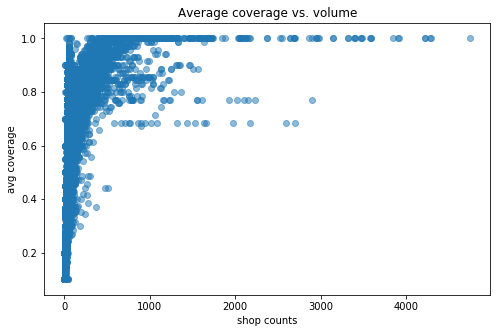

In [70]:
plot_vol_vs_coverage(pos_cov_summ_pdf)

In [71]:
market_list_sorted = sort_markets_by_dtd_covg(pos_cov_summ_pdf, 30)
# market_list_sorted[:5]
len(market_list_sorted)

308

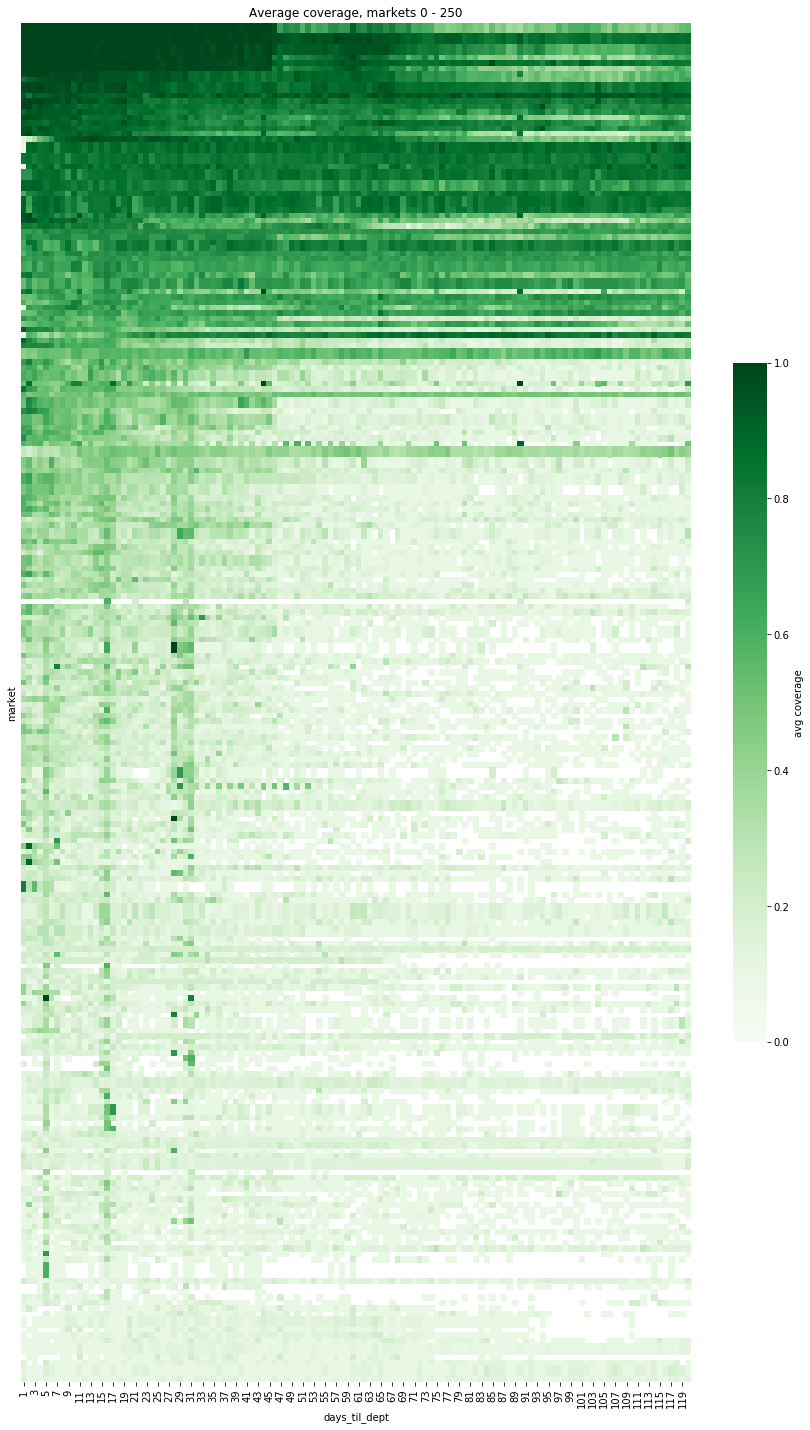

In [72]:
plot_stacked_market_heatmap(pos_cov_summ_pdf, market_list_sorted, 0, 250, False)

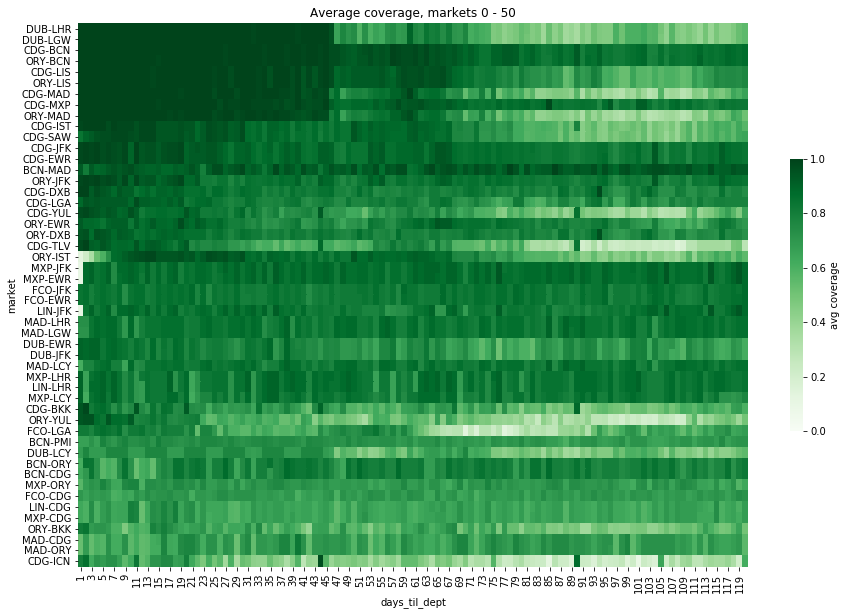

In [75]:
plot_stacked_market_heatmap(pos_cov_summ_pdf, market_list_sorted, 0, 50, True)

/opt/anaconda/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


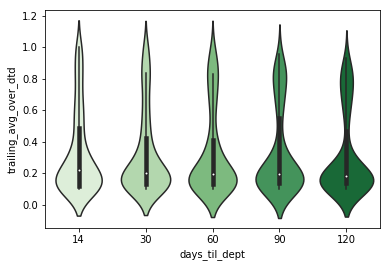

In [73]:
plot_violin_distro_vs_dtd(pos_cov_summ_pdf)

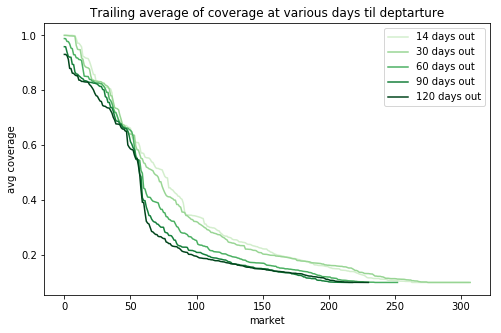

In [74]:
line_plot_coverage_vs_dtd(pos_cov_summ_pdf, use_color_map=True)

# Hong Kong

In [76]:
pos = 'HK'
# note we aren't filtering on HK ORG/DST
pos_cov_summ_pdf = analyze_pos(cov_df, pos, los_start, los_end, filter_on_org_dst=False)
# pos_cov_summ_pdf.head()

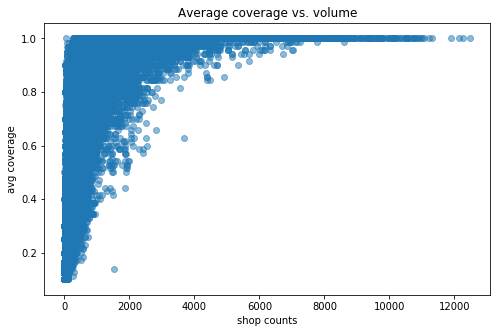

In [77]:
plot_vol_vs_coverage(pos_cov_summ_pdf)

In [78]:
market_list_sorted = sort_markets_by_dtd_covg(pos_cov_summ_pdf, 30)
# market_list_sorted[:5]
len(market_list_sorted)

980

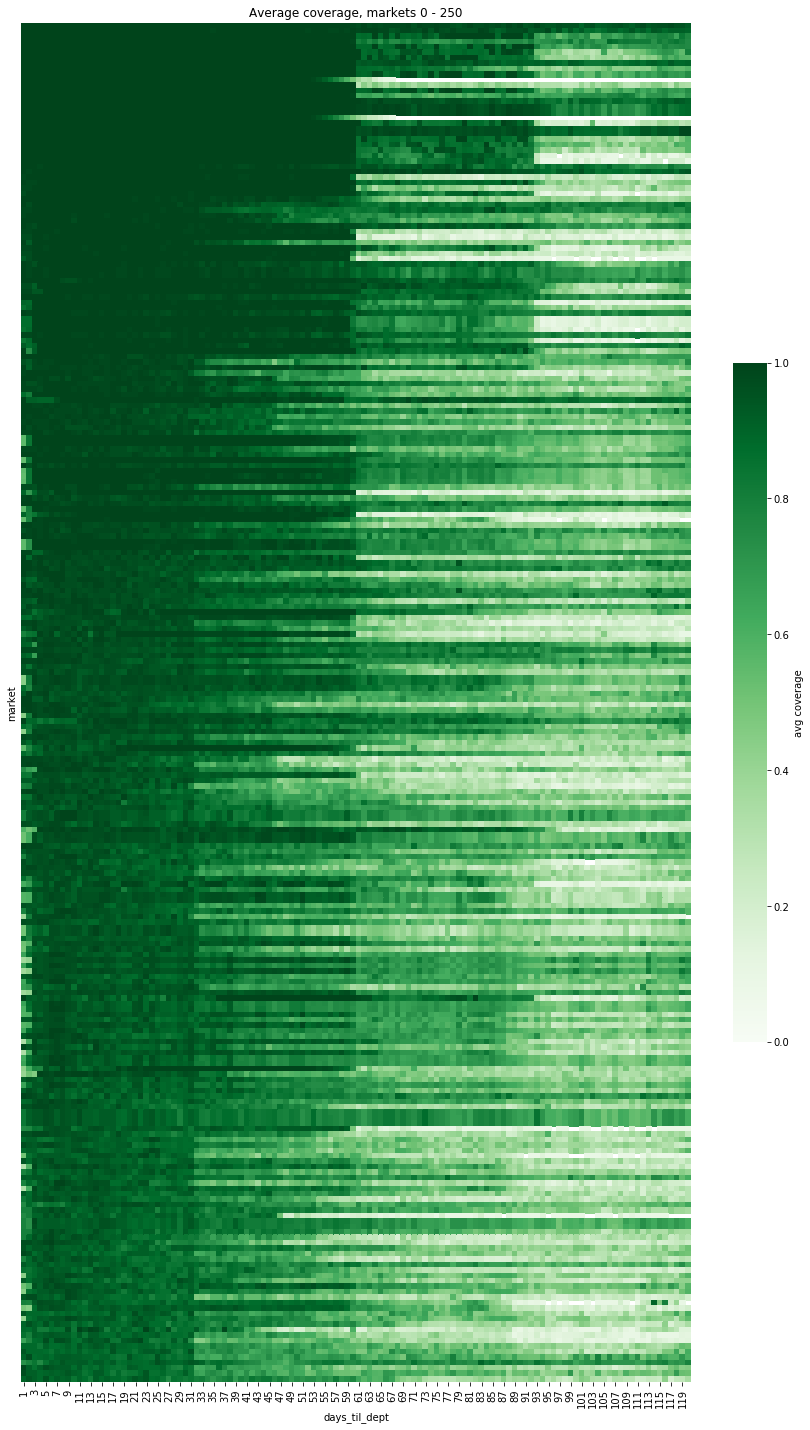

In [79]:
# plot_stacked_market_heatmap(pos_cov_summ_pdf, market_list_sorted, 0, 50, True)
plot_stacked_market_heatmap(pos_cov_summ_pdf, market_list_sorted, 0, 250, False)

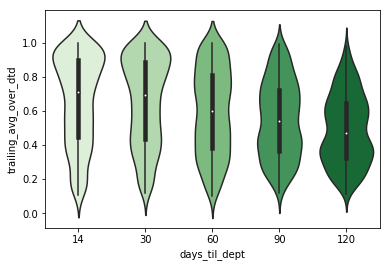

In [80]:
plot_violin_distro_vs_dtd(pos_cov_summ_pdf)

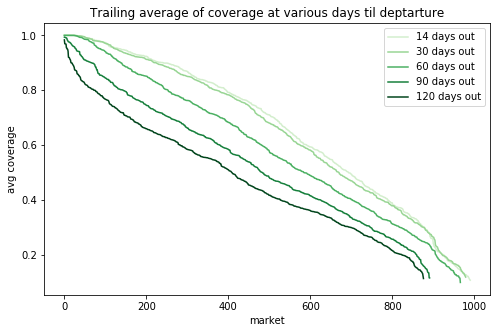

In [81]:
line_plot_coverage_vs_dtd(pos_cov_summ_pdf, use_color_map=True)

# Canada

In [97]:
pos = 'CA'
pos_cov_summ_pdf = analyze_pos(cov_df, pos, los_start, los_end, filter_on_org_dst=True)
# pos_cov_summ_pdf.head()

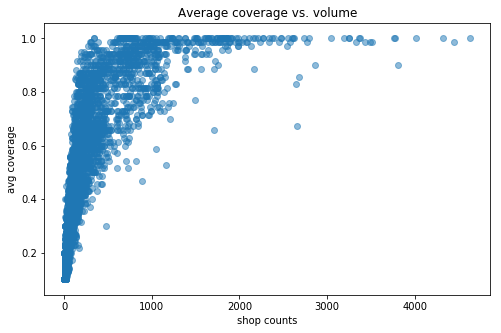

In [98]:
plot_vol_vs_coverage(pos_cov_summ_pdf)

In [99]:
market_list_sorted = sort_markets_by_dtd_covg(pos_cov_summ_pdf, 60)
# market_list_sorted[:5]
len(market_list_sorted)

32

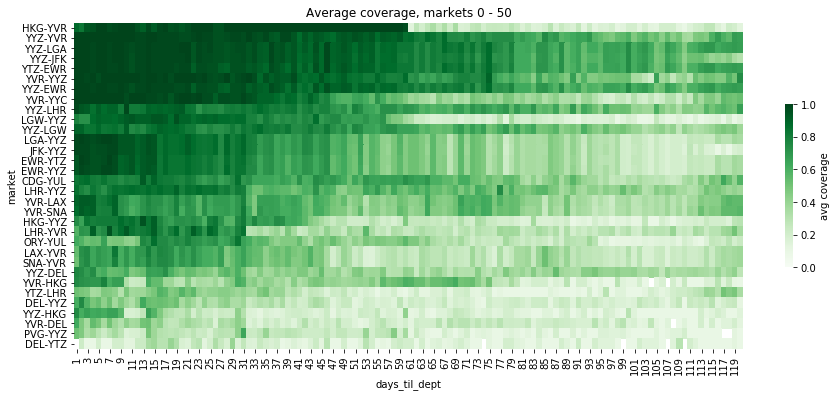

In [100]:
plot_stacked_market_heatmap(pos_cov_summ_pdf, market_list_sorted, 0, 50, True)
# plot_stacked_market_heatmap(pos_cov_summ_pdf, market_list_sorted, 0, 250, False)

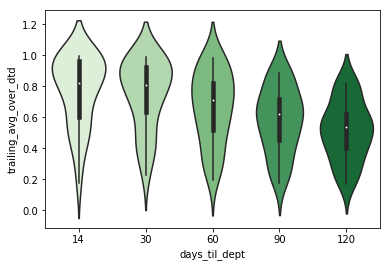

In [101]:
plot_violin_distro_vs_dtd(pos_cov_summ_pdf)

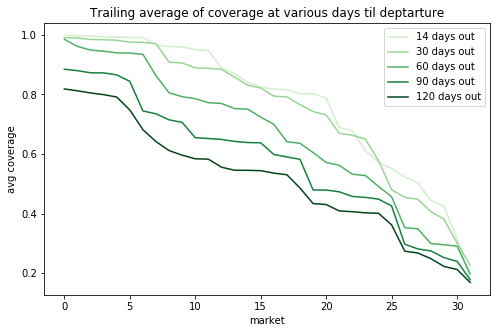

In [102]:
line_plot_coverage_vs_dtd(pos_cov_summ_pdf, use_color_map=True)

### All Markets

In [82]:
pos = 'CA'
pos_cov_summ_pdf = analyze_pos(cov_df, pos, los_start, los_end, filter_on_org_dst=False)
# pos_cov_summ_pdf.head()

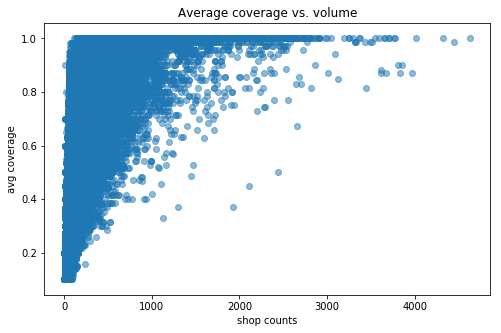

In [83]:
plot_vol_vs_coverage(pos_cov_summ_pdf)

In [86]:
market_list_sorted = sort_markets_by_dtd_covg(pos_cov_summ_pdf, 60)
# market_list_sorted[:5]
len(market_list_sorted)

870

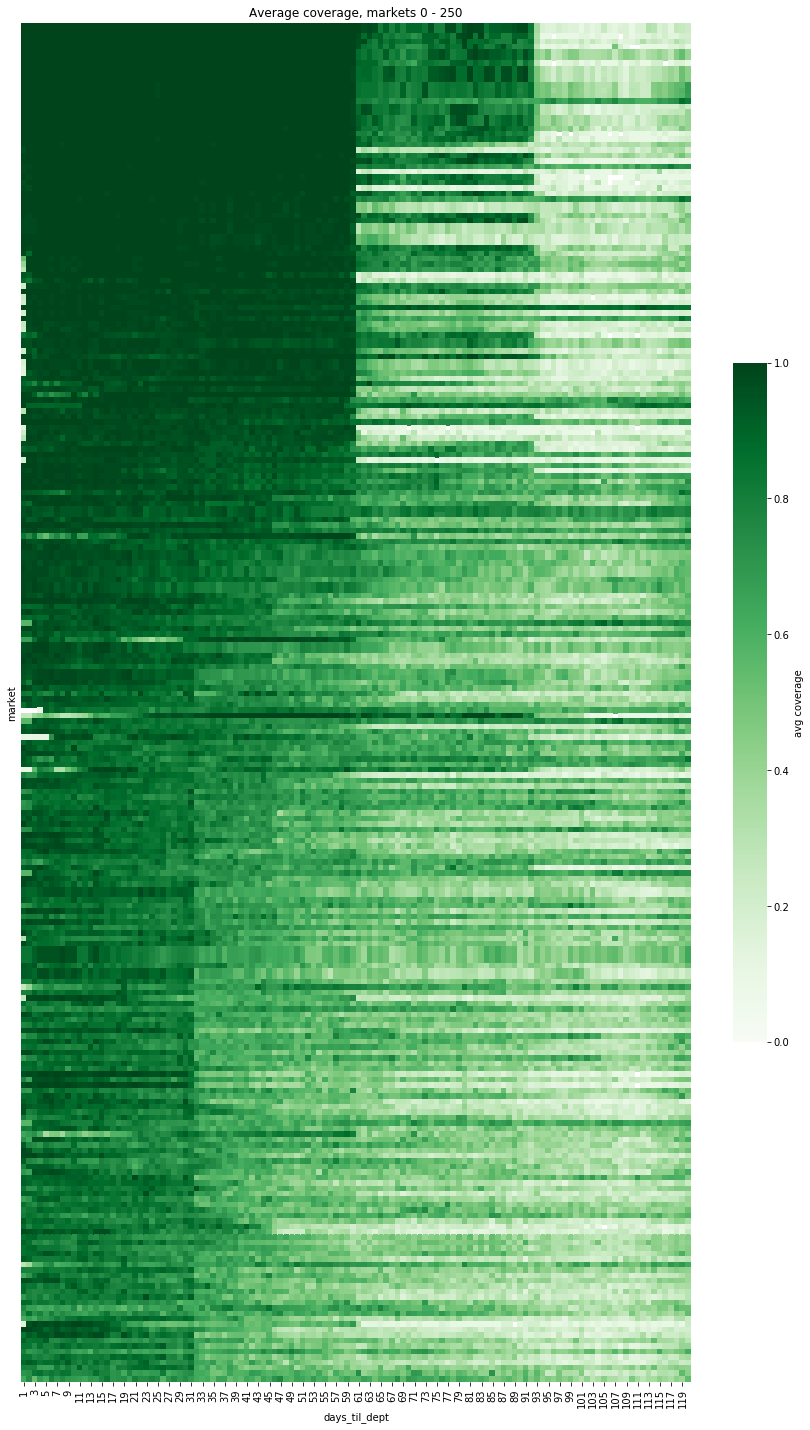

In [87]:
# plot_stacked_market_heatmap(pos_cov_summ_pdf, market_list_sorted, 0, 50, True)
plot_stacked_market_heatmap(pos_cov_summ_pdf, market_list_sorted, 0, 250, False)

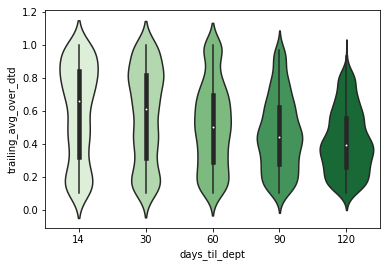

In [88]:
plot_violin_distro_vs_dtd(pos_cov_summ_pdf)

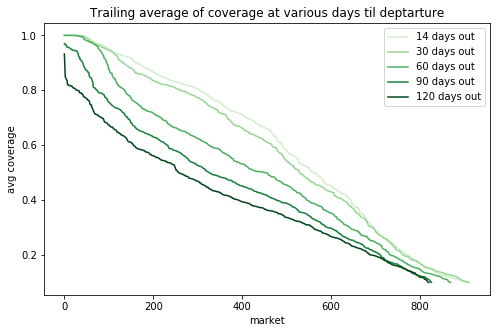

In [89]:
line_plot_coverage_vs_dtd(pos_cov_summ_pdf, use_color_map=True)

# Australia

In [90]:
pos = 'AU'
pos_cov_summ_pdf = analyze_pos(cov_df, pos, los_start, los_end, filter_on_org_dst=False)
# pos_cov_summ_pdf.head()

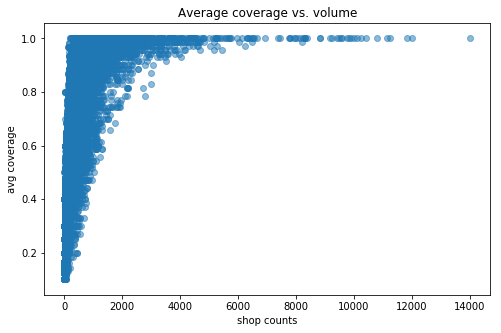

In [91]:
plot_vol_vs_coverage(pos_cov_summ_pdf)

In [92]:
market_list_sorted = sort_markets_by_dtd_covg(pos_cov_summ_pdf, 30)
# market_list_sorted[:5]
len(market_list_sorted)

820

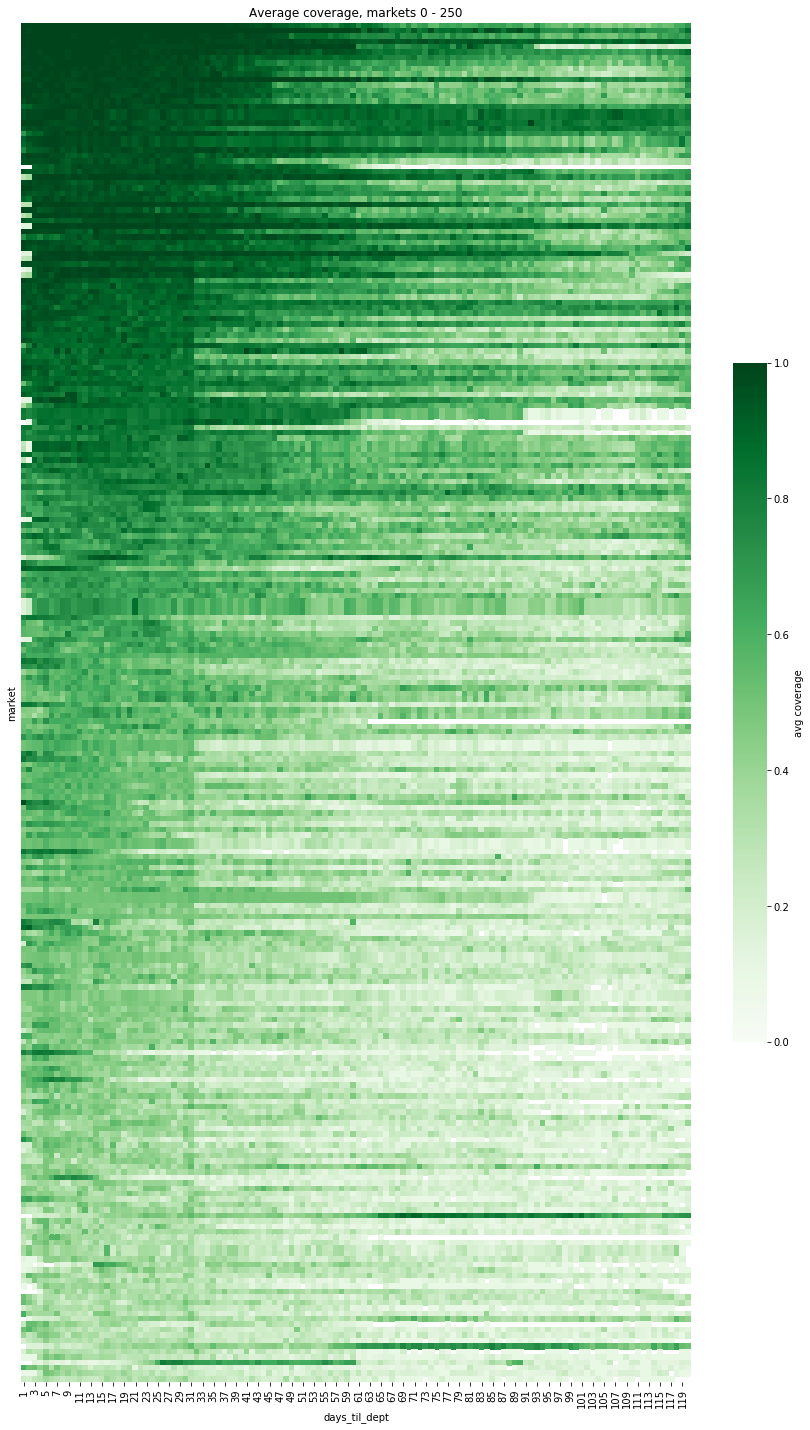

In [93]:
# plot_stacked_market_heatmap(pos_cov_summ_pdf, market_list_sorted, 0, 50, True)
plot_stacked_market_heatmap(pos_cov_summ_pdf, market_list_sorted, 0, 250, False)

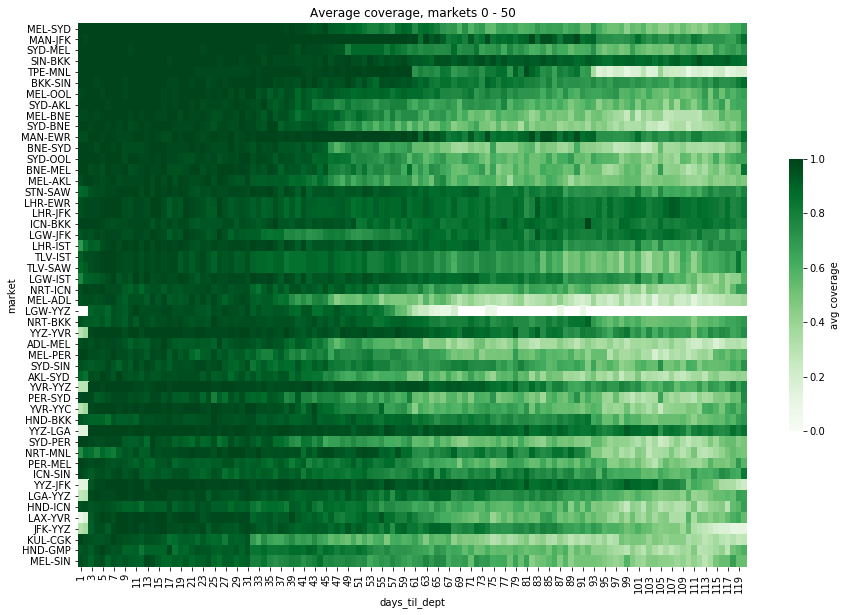

In [96]:
plot_stacked_market_heatmap(pos_cov_summ_pdf, market_list_sorted, 0, 50, True)

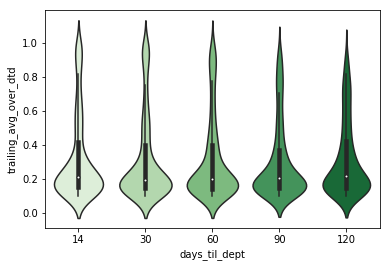

In [94]:
plot_violin_distro_vs_dtd(pos_cov_summ_pdf)

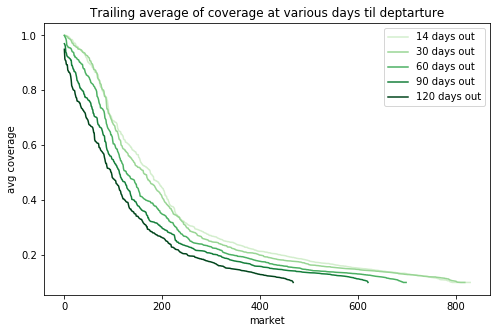

In [95]:
line_plot_coverage_vs_dtd(pos_cov_summ_pdf, use_color_map=True)

# Check that I'm doing those violin plots correctly/

In [103]:
pos = 'CA'
pos_cov_summ_pdf = analyze_pos(cov_df, pos, los_start, los_end, filter_on_org_dst=False)

In [105]:
dtd_list=[14, 30, 60, 90, 120]
covg_summ_filt_pdf = pos_cov_summ_pdf[pos_cov_summ_pdf['days_til_dept'].isin(dtd_list)]

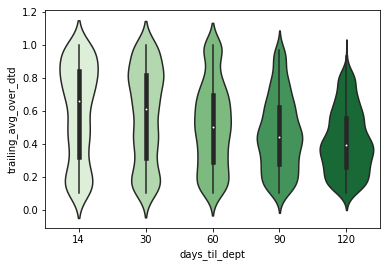

In [107]:
sns.violinplot(data=covg_summ_filt_pdf,
               x= 'days_til_dept',
               y='trailing_avg_over_dtd',
               palette="Greens");

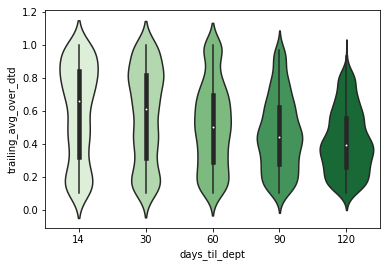

In [108]:
sns.violinplot(covg_summ_filt_pdf['days_til_dept'], covg_summ_filt_pdf['trailing_avg_over_dtd'], palette="Greens");

Yup, they look the same. Gosh, seaborn is smart.

In [22]:
pos_cov_summ_pdf.head()

,market,days_til_dept,avg_coverage,shop_counts,trailing_avg_over_dtd,sum_counts
0,MAA-SIN,1,1.000000,1030,1.000000,1030
1,MAA-SIN,2,0.985714,934,0.992857,1964
2,MAA-SIN,3,0.971429,878,0.985714,2842
3,MAA-SIN,4,0.971429,803,0.982143,3645
4,MAA-SIN,5,0.971429,1439,0.980000,5084


# template

In [ ]:
pos = ''
pos_cov_summ_pdf = analyze_pos(cov_df, pos, los_start, los_end, filter_on_org_dst=False)
# pos_cov_summ_pdf.head()

In [ ]:
plot_vol_vs_coverage(pos_cov_summ_pdf)

In [ ]:
market_list_sorted = sort_markets_by_dtd_covg(pos_cov_summ_pdf, 30)
# market_list_sorted[:5]
len(market_list_sorted)

In [ ]:
# plot_stacked_market_heatmap(pos_cov_summ_pdf, market_list_sorted, 0, 50, True)
plot_stacked_market_heatmap(pos_cov_summ_pdf, market_list_sorted, 0, 250, False)

In [ ]:
plot_violin_distro_vs_dtd(pos_cov_summ_pdf)

In [ ]:
line_plot_coverage_vs_dtd(pos_cov_summ_pdf, use_color_map=True)

# TAKE-AWAYS

"Good" markets (defined by POS) to pursue customers in:
- US

Less good:
- France


# dev new plot

This is for pOS=IN, filter on org dtd = True

In [23]:
pos_cov_summ_pdf.head()

,market,days_til_dept,avg_coverage,shop_counts,trailing_avg_over_dtd,sum_counts
0,MAA-SIN,1,1.000000,1030,1.000000,1030
1,MAA-SIN,2,0.985714,934,0.992857,1964
2,MAA-SIN,3,0.971429,878,0.985714,2842
3,MAA-SIN,4,0.971429,803,0.982143,3645
4,MAA-SIN,5,0.971429,1439,0.980000,5084


In [32]:
def scatter_coverage_vs_vol_by_dtd(covg_summ_pdf, dtd_list=[14, 30, 60, 90, 120]):
    cmap_name = "Greens"#"GnBu"
    colors = [cm.get_cmap(cmap_name)(x) for x in np.linspace(0, 1, len(dtd_list)+1)]

    plt.figure(figsize=(8,5))
    for i, dtd in enumerate(dtd_list):
        line_plot_df = covg_summ_pdf[covg_summ_pdf['days_til_dept'] == dtd]
        line_plot_df = line_plot_df.sort_values(by=["sum_counts"],
                                ascending=[False],
                                )#.reset_index(drop=True)
        plt.scatter(line_plot_df['sum_counts'], line_plot_df['trailing_avg_over_dtd'],
                color=colors[i+1],
                label=f"{dtd} days out");    
        plt.legend();
        plt.title("Coverage vs volume for various days til deptarture");
        plt.ylabel("avg coverage")
        plt.xlabel("shop volume");

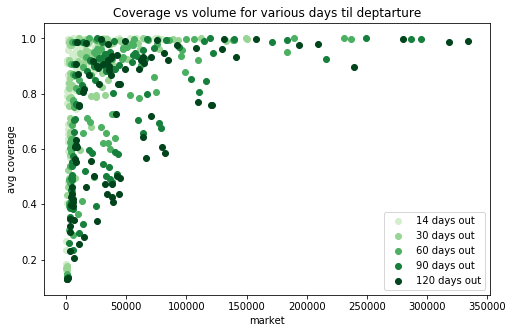

In [29]:
scatter_coverage_vs_vol_by_dtd(pos_cov_summ_pdf)

Let's plot for US

In [30]:
pos = 'US'
pos_cov_summ_pdf = analyze_pos(cov_df, pos, los_start, los_end, filter_on_org_dst=True)

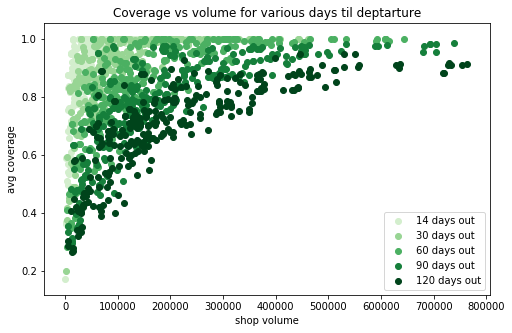

In [33]:
scatter_coverage_vs_vol_by_dtd(pos_cov_summ_pdf)

I actually don't think this tell us anything useful/new
- see same decreasing levels of coverage by increasing days until departure
- the shop volume is trailing sum over dtd, which obfuscates / abstracts from relationship we are trying to show

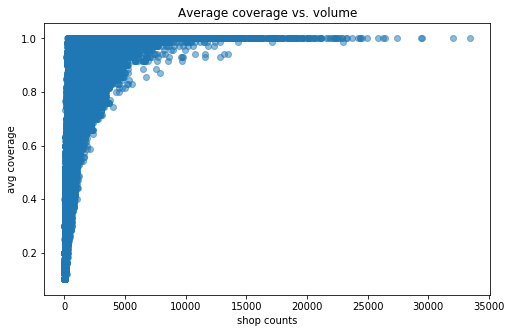

In [34]:
plot_vol_vs_coverage(pos_cov_summ_pdf)

In [35]:
pos_cov_summ_pdf.head()

,market,days_til_dept,avg_coverage,shop_counts,trailing_avg_over_dtd,sum_counts
0,LGW-JFK,1,1.0,6013,1.0,6013
1,LGW-JFK,2,1.0,5522,1.0,11535
2,LGW-JFK,3,1.0,6804,1.0,18339
3,LGW-JFK,4,1.0,6859,1.0,25198
4,LGW-JFK,5,1.0,9124,1.0,34322
